## **Initialization and Parameter Setting**

The state of the five edges is represented by **component events**.  
Each edge can take a **binary state**:  
- `0`: Non-functional  
- `1`: Functional  

### **Edge Probabilities**
```python
probs = {
    'e1': {0: 0.01, 1: 0.99},
    'e2': {0: 0.01, 1: 0.99},
    'e3': {0: 0.05, 1: 0.95},
    'e4': {0: 0.05, 1: 0.95},
    'e5': {0: 0.10, 1: 0.90}
}

In [35]:
import sys
sys.path.append(r"D:\MINJI\NETWORK RELIABILITY\BNS-JT-python")

import itertools
import numpy as np
import networkx as nx
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from itertools import combinations
from networkx.algorithms.flow import shortest_augmenting_path
from BNS_JT import cpm, variable, operation
from BNS_JT import brc
import pandas as pd


# Define the network
nodes = {'n1': (0, 0),
         'n2': (1, 1),
         'n3': (1, -1),
         'n4': (2, 0)}

edges = {'e1': ['n1', 'n2'],
         'e2': ['n1', 'n3'],
         'e3': ['n2', 'n3'],
         'e4': ['n2', 'n4'],
         'e5': ['n3', 'n4']}

probs = {'e1': {0: 0.01, 1: 0.99}, 'e2': {0: 0.01, 1: 0.99}, 'e3': {0: 0.05, 1: 0.95},
         'e4': {0: 0.05, 1: 0.95}, 'e5': {0: 0.10, 1: 0.90}}

varis = {}
for k, v in edges.items():
    varis[k] = variable.Variable( name=k, values = [0, 1]) # values: edge flow capacity

## **Functions for Reliability Index and Redundancy Index**
#### **Beta Calculation**
$$
\beta_{ij} = -\Phi^{-1}\left(P(F_i \mid H_j)\right)
$$

In [36]:
def calculate_beta(probs):
    # 상태 조합 생성 (0: failure / 1: survival)
    state_combinations = list(itertools.product([0, 1], repeat=len(probs)))

    # Failure probability 계산
    failure_probabilities = []
    for state in state_combinations:
        probabilities = [
            probs[edge][state[i]]  # state[i]에 따라 적절한 확률 값 선택
            for i, edge in enumerate(probs.keys())
        ]
        failure_prob = np.prod(probabilities)
        failure_probabilities.append((state, failure_prob))

    # Beta 계산
    beta_results = []
    for state, failure_prob in failure_probabilities:
        if all(state):  # 모든 엣지가 생존하는 상태는 제외
            continue
        if failure_prob > 0:
            beta = -norm.ppf(failure_prob)
        else:
            beta = float('inf')  # 확률이 0일 경우 베타는 무한대
        # State를 문자열로 변환하여 저장
        beta_results.append((''.join(map(str, state)), failure_prob, beta))
    
    return beta_results, state_combinations, failure_probabilities

In [37]:
beta_results, state_combinations, failure_probabilities = calculate_beta(probs)
df_beta_results = pd.DataFrame(beta_results, columns=['State', 'Failure Probability', 'Beta'])
print(df_beta_results.to_string(index=False)) 

State  Failure Probability     Beta
00000         2.500000e-08 5.451310
00001         2.250000e-07 5.046490
00010         4.750000e-07 4.901722
00011         4.275000e-06 4.450928
00100         4.750000e-07 4.901722
00101         4.275000e-06 4.450928
00110         9.025000e-06 4.287740
00111         8.122500e-05 3.771222
01000         2.475000e-06 4.566896
01001         2.227500e-05 4.082520
01010         4.702500e-05 3.905451
01011         4.232250e-04 3.337141
01100         4.702500e-05 3.905451
01101         4.232250e-04 3.337141
01110         8.934750e-04 3.123531
01111         8.041275e-03 2.407037
10000         2.475000e-06 4.566896
10001         2.227500e-05 4.082520
10010         4.702500e-05 3.905451
10011         4.232250e-04 3.337141
10100         4.702500e-05 3.905451
10101         4.232250e-04 3.337141
10110         8.934750e-04 3.123531
10111         8.041275e-03 2.407037
11000         2.450250e-04 3.486137
11001         2.205225e-03 2.847208
11010         4.655475e-03 2

- **MCS이용한 방법과 beta 결과 비교** - 거의 동일하게 나옴

모두 fail한 경우 [0,0,0,0,0]의 베타값이 차이가 좀 크게 나옴
이유 : MCS의 경우 케이스 별 확률 값에 비례하게 sampling되는데 해당 케이크스의 경우 Pf=0.0000000250로, 한 번도 샘플링되지 않음 -> 튀어보이는 결과 도출

In [38]:
# 첫 번째 결과 (Failure Probability and Beta values)
result1 = [
    ("00000", 5.4513), ("00001", 5.0465), ("00010", 4.9017), ("00011", 4.4509),
    ("00100", 4.9017), ("00101", 4.4509), ("00110", 4.2877), ("00111", 3.7712),
    ("01000", 4.5669), ("01001", 4.0825), ("01010", 3.9055), ("01011", 3.3371),
    ("01100", 3.9055), ("01101", 3.3371), ("01110", 3.1235), ("01111", 2.4070),
    ("10000", 4.5669), ("10001", 4.0825), ("10010", 3.9055), ("10011", 3.3371),
    ("10100", 3.9055), ("10101", 3.3371), ("10110", 3.1235), ("10111", 2.4070),
    ("11000", 3.4861), ("11001", 2.8472), ("11010", 2.6004), ("11011", 1.7291),
    ("11100", 2.6004), ("11101", 1.7291), ("11110", 1.3503)
]

# 두 번째 결과 (Scenario Subset and Beta values, flipped states)
result2 = [
    ("11110", 1.349946), ("11101", 1.728809), ("11100", 2.600920), ("11011", 1.730381),
    ("11010", 2.603534), ("11001", 2.845886), ("11000", 3.493015), ("10111", 2.406913),
    ("10110", 3.123062), ("10101", 3.335194), ("10100", 3.908164), ("10011", 3.326957),
    ("10010", 3.907127), ("10001", 4.067109), ("10000", 4.506196), ("01111", 2.407004),
    ("01110", 3.127800), ("01101", 3.334412), ("01100", 3.906610), ("01011", 3.340658),
    ("01010", 3.888177), ("01001", 4.082259), ("01000", 4.573344), ("00111", 3.763428),
    ("00110", 4.331644), ("00101", 4.476153), ("00100", 4.935367), ("00011", 4.454727),
    ("00010", 4.753424), ("00001", 5.199338), ("00000", 7.034484)
]

# Convert results to dictionaries for easy comparison
beta1_dict = dict(result1)
beta2_dict = dict(result2)

# Compare beta values for matching states
comparison = []
for state in beta1_dict.keys():
    if state in beta2_dict:
        beta1 = beta1_dict[state]
        beta2 = beta2_dict[state]
        difference = abs(beta1 - beta2)
        comparison.append((state, beta1, beta2, difference))

# Sort by difference for better analysis
comparison = sorted(comparison, key=lambda x: x[3], reverse=True)

# Output results
print(f"{'State':>10} | {'Beta1':>10} | {'Beta2':>10} | {'Difference':>10}")
print("-" * 50)
for state, beta1, beta2, diff in comparison:
    print(f"{state:>10} | {beta1:>10.4f} | {beta2:>10.4f} | {diff:>10.4f}")


     State |      Beta1 |      Beta2 | Difference
--------------------------------------------------
     00000 |     5.4513 |     7.0345 |     1.5832
     00001 |     5.0465 |     5.1993 |     0.1528
     00010 |     4.9017 |     4.7534 |     0.1483
     10000 |     4.5669 |     4.5062 |     0.0607
     00110 |     4.2877 |     4.3316 |     0.0439
     00100 |     4.9017 |     4.9354 |     0.0337
     00101 |     4.4509 |     4.4762 |     0.0253
     01010 |     3.9055 |     3.8882 |     0.0173
     10001 |     4.0825 |     4.0671 |     0.0154
     10011 |     3.3371 |     3.3270 |     0.0101
     00111 |     3.7712 |     3.7634 |     0.0078
     11000 |     3.4861 |     3.4930 |     0.0069
     01000 |     4.5669 |     4.5733 |     0.0064
     01110 |     3.1235 |     3.1278 |     0.0043
     00011 |     4.4509 |     4.4547 |     0.0038
     01011 |     3.3371 |     3.3407 |     0.0036
     11010 |     2.6004 |     2.6035 |     0.0031
     01101 |     3.3371 |     3.3344 |     0.0027

#### **Pi Calculation**

$$
\begin{align*}
\pi_{ij} & = -\Phi^{-1}\left(P(F_{\text{sys}} \mid F_i, H_j)\right) \\
         & = -\Phi^{-1}\left(\frac{P(F_{\text{sys}}, F_i)}{P(F_i)}\right) \\
         & = -\Phi^{-1}\left(
         \frac{
         \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 0} p
         + \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 1 \text{ and } \boldsymbol{l}\langle X_i \rangle = 0} \left(p \cdot P(F_i)\right)
         + \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 1 \text{ and } \boldsymbol{l}\langle X_i \rangle = 1} 0
         }{P(F_i)}
         \right)
\end{align*}
$$

- ***System event***

System state is evaluated by network connectivity between a designed origin-destination (OD) pair. <br>
In other words, a system state is survival if the OD pair is connected; and failure otherwise.

In [39]:
def net_conn(comps_st, od_pair, edges, varis): # maximum flow analysis

    G = nx.Graph()
    for k,x in comps_st.items():
        G.add_edge(edges[k][0], edges[k][1]) # we add each edge
        G[edges[k][0]][edges[k][1]]['capacity'] = varis[k].values[x] # define capacity as 0 if state = 0 or 1 if state = 1

    # perform maximum flow analysis between the OD pair
    G.add_edge(od_pair[1], 'new_d', capacity=1) # add a new edge with capacity 1 to ensure we find only ONE path. 
    f_val, f_dict = nx.maximum_flow(G, od_pair[0], 'new_d', capacity='capacity', flow_func=shortest_augmenting_path)

    if f_val > 0: # if the flow between the OD pair is greater than 0, the two nodes are connected
        sys_st = 's'

        # We can infer an associated minimum survival rule in case of network connectivity.
        min_comps_st = {} 
        for k, x in comps_st.items():
            k_flow = max([f_dict[edges[k][0]][edges[k][1]], f_dict[edges[k][1]][edges[k][0]]])
            if k_flow > 0: # the edges with flows > 0 consitute a minimum survival rule.
                min_comps_st[k] = 1

    else:
        sys_st = 'f'

        # In case of system failure, obtaining a minimum failure rule is not straightforward.
        min_comps_st = None

    return f_val, sys_st, min_comps_st

In this example, we consider the OD pair 'n1' and 'n4'.

In [40]:
od_pair=('n1','n4')

To run the BRC algorithm, a system function needs to have only one input **components state.**

This can be done using a lambda function.

In [41]:
sys_fun = lambda comps_st : net_conn(comps_st, od_pair, edges, varis)

- **Application of the BRC Algorithm**

In [42]:
brs, rules, sys_res, monitor = brc.run(varis, probs, sys_fun, max_sf=np.inf, max_nb=np.inf, pf_bnd_wr=0.0)

*** Analysis completed with f_sys runs 8: out_flag = complete ***
The # of found non-dominated rules (f, s): 8 (4, 4)
Probability of branchs (f, s, u): (5.1688e-03, 9.95e-01, 0.0000e+00)
The # of branches (f, s, u), (min, avg) len of rf: 11 (5, 6, 0), (2, 2.50)


- **Pi calculation**

In [43]:
def calculate_pi(brs, probs, beta_results):
    # Extract state combinations and failure probabilities from beta_results
    state_combinations = [state for state, _, _ in beta_results]

    results = []
    for state_idx, state in enumerate(state_combinations):
        pf_i = beta_results[state_idx][1]  # 해당 state의 실패 확률 가져오기

        # 모든 branch에서 해당 state를 고려
        failure_branches = [
            branch for branch in brs
            if all(branch.down[list(probs.keys())[i]] == int(state[i]) for i in range(len(state)))
        ]

        # P(Fsys | state) 계산
        sum_p1 = 0  # u[Xi] = 0
        sum_p2 = 0  # u[Xi] = 1 and l[Xi] = 0
        for branch in failure_branches:
            down, up, p = branch.down, branch.up, branch.p
            if all(up[list(probs.keys())[i]] == int(state[i]) for i in range(len(state))):
                # Case: u[Xi] = 0 for all i in the state
                sum_p1 += p
            elif all(up[list(probs.keys())[i]] >= int(state[i]) and down[list(probs.keys())[i]] == int(state[i]) for i in range(len(state))):
                # Case: u[Xi] >= state[i] and l[Xi] = state[i]
                contribution = p * pf_i
                sum_p2 += contribution

        numerator = sum_p1 + sum_p2

        if pf_i > 0:
            pf_sys_given_state = numerator / pf_i
        else:
            pf_sys_given_state = 0  # P(Fsys | F_comb) is 0 if pf_i is 0

        # π_ij 계산: π_ij = Φ(-P(F_sys | F_i, H_j))
        if pf_sys_given_state > 0:
            pi_ij = norm.cdf(-pf_sys_given_state)
        else:
            pi_ij = 1  # Φ(0) = 1

        results.append({
            'State': state,
            'P(Fsys | state)': pf_sys_given_state,
            'π_ij': pi_ij
        })

    return results

In [44]:
# π 계산 함수 호출
pi_results = calculate_pi(brs, probs, beta_results)

# 결과를 DataFrame으로 변환
df_pi_results = pd.DataFrame(pi_results)

# 원하는 열만 선택
df_pi_table = df_pi_results[['State', 'P(Fsys | state)', 'π_ij']]

# 테이블 형식 출력
print("State, P(Fsys | state), π_ij 결과 (테이블 형식):")
print(df_pi_table)

State, P(Fsys | state), π_ij 결과 (테이블 형식):
    State  P(Fsys | state)      π_ij
0   00000         0.000100  0.499960
1   00001         0.000000  1.000000
2   00010         0.000000  1.000000
3   00011         0.000000  1.000000
4   00100         0.000000  1.000000
5   00101         0.000000  1.000000
6   00110         0.000000  1.000000
7   00111         0.000000  1.000000
8   01000         0.000050  0.499980
9   01001         0.000446  0.499822
10  01010         0.000000  1.000000
11  01011         0.000000  1.000000
12  01100         1.000000  0.158655
13  01101         1.000000  0.158655
14  01110         0.008935  0.496436
15  01111         0.000000  1.000000
16  10000         0.004950  0.498025
17  10001         1.000000  0.158655
18  10010         0.940500  0.173481
19  10011         0.000000  1.000000
20  10100         0.000000  1.000000
21  10101         1.000000  0.158655
22  10110         0.000000  1.000000
23  10111         0.000000  1.000000
24  11000         0.000000  1.000

In [45]:
# Step 1: β 계산
beta_results, state_combinations, failure_probabilities = calculate_beta(probs)
df_beta_results = pd.DataFrame(beta_results, columns=['State', 'Failure Probability', 'Beta'])

# Step 2: π 계산
pi_results = calculate_pi(brs, probs, beta_results)
df_pi_results = pd.DataFrame(pi_results)

# Step 3: β-π Diagram 생성
# β와 π 값을 입력
beta_values = df_beta_results['Beta'].values
pi_values = df_pi_results['π_ij'].values
state_labels = df_pi_results['State'].values  # MECE 상태 레이블

# 실패한 엣지의 수 계산
failed_elements = [state.count('0') for state in state_labels]

# 고유 실패 부재 수 및 색상 정의
unique_fail_counts = np.unique(failed_elements)
dominant_colors_hex = ['#f28b82', '#fbbc04', '#fff475', '#ccff90', '#aecbfa', '#d7aefb']
colors = [to_rgb(color) for color in dominant_colors_hex]

plt.figure(figsize=(8, 8))  # 플롯 크기 설정

# β-π Diagram의 산점도
for count, color in zip(unique_fail_counts, colors):
    indices = [i for i, x in enumerate(failed_elements) if x == count]
    plt.scatter(np.array(pi_values)[indices], np.array(beta_values)[indices],
                color=color, s=200, label=f"{count} Element Fail",
                edgecolors='k', alpha=0.7)

# β-π 임계값 선 추가
prob_targets = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reverse_labels = [r'$\lambda_{H_j} = 10^{-5}$', r'$\lambda_{H_j} = 10^{-4}$',
                  r'$\lambda_{H_j} = 10^{-3}$', r'$\lambda_{H_j} = 10^{-2}$',
                  r'$\lambda_{H_j} = 10^{-1}$']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]

for prob_target, line_style, label in zip(prob_targets, line_styles, reverse_labels):
    beta_threshold = np.arange(-3, 8, 0.01)  # 스텝 크기를 최적화
    pi_threshold = -norm.ppf(prob_target / norm.cdf(-beta_threshold))
    plt.plot(pi_threshold, beta_threshold, 'indianred', linestyle=line_style,
             label=label, alpha=0.8)

# 플롯 커스터마이징
plt.title(r'$\beta - \pi$ Diagram with Thresholds', fontsize=16)
plt.xlabel('Redundancy (π)', fontsize=12)
plt.ylabel('Reliability (β)', fontsize=12)
plt.axis('equal')
plt.xlim([-3, 7])
plt.ylim([-3, 7])
plt.grid(alpha=0.5)
plt.legend(title="Failure Scenarios and Thresholds", fontsize=10, loc="best")
plt.tight_layout()

# 그래프 출력
plt.show(block=False)

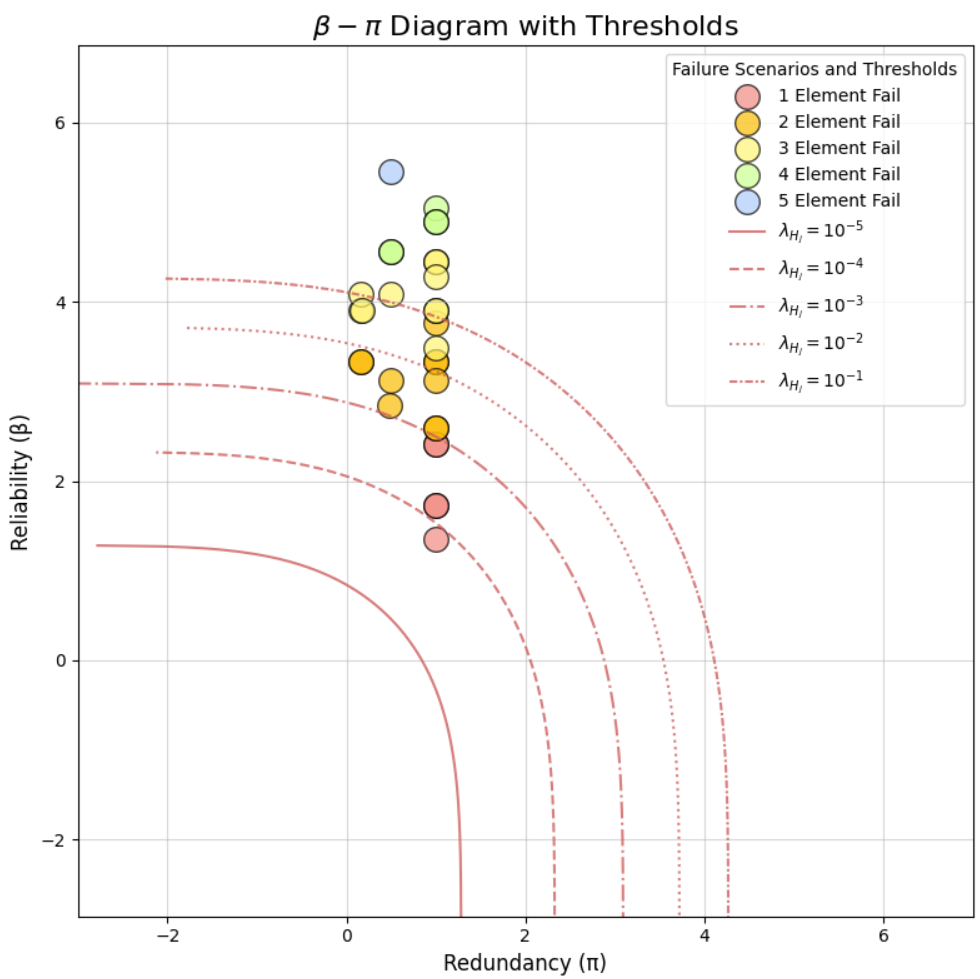

In [46]:
from IPython.display import Image, display

# PNG 파일 경로
png_file = "figure.png"

# PNG 이미지 표시
display(Image(filename=png_file))
